In [ ]:
!nvidia-smi
#!apt-get install -y nvidia-driver-450
#use this code to install the driver

Wed Jun 12 06:21:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Clip Architecture

In [ ]:
!git clone https://github.com/openai/CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 256 (delta 6), reused 4 (delta 0), pack-reused 243
Receiving objects: 100% (256/256), 8.93 MiB | 16.09 MiB/s, done.
Resolving deltas: 100% (130/130), done.


# TAMING-TRANSFORMER ARCHITECTURE

In [ ]:
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [ ]:
 # We Need to install some more libraries as well
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 9.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
#import IMAGE, NUMPY, PANDAS, MATPLOTLIB Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL

In [ ]:
#import PYTORCH libraries
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [ ]:
import yaml
from omegaconf import OmegaConf

from CLIP import clip

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#create helper function for CLIP

def show_from_tensor(tensor):
  img=tensor.clone()
  img=img.mul(255).byte()
  img=img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return(data.clip(-1,1)+1)/2 ##range between 0 and 1 in the result

#parameters
learning_rate=.5
batch_size=1
wd=.1
noise_factor=.22

total_iter=400
im_shape=[450,450,3] #height, width, channel
size1,size2,channels=im_shape

In [ ]:
##CLIP MODEL
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution:",clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache()

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 36.9MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution: 224


In [ ]:
## Taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'


/content/taming-transformers
--2024-06-12 06:24:13--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/37008061-a96c-4cf7-9769-31ec0c67d06c/last.ckpt [following]
--2024-06-12 06:24:14--  https://heibox.uni-heidelberg.de/seafhttp/files/37008061-a96c-4cf7-9769-31ec0c67d06c/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  11.7MB/s    in 87s     

2024-06-12 06:25:41 (10.7 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [ ]:
### Declare the values that we are going to optimize

class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters,self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda()
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params=Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data],'lr': learning_rate}], weight_decay=wd)
  return params, optimizer

In [ ]:
### create crops

def create_crops(img, num_crops=32):
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops

In [ ]:
### Show current state of generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [ ]:
# Optimization process

def optimize_result(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  ## image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc=clipmodel.encode_image(out) ## 30 x 512

  ## text encoding  w1 and w2
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss


In [ ]:
### training loop

def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss:", loss.item(), "\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z

Augmented cropped example


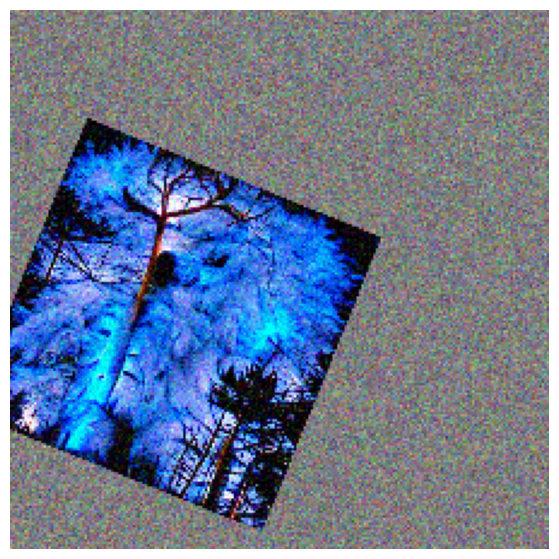

Generation


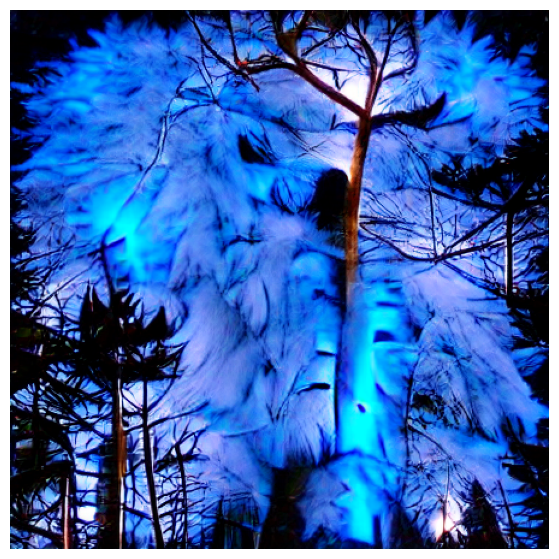

loss: -0.223388671875 
iteration: 80
Augmented cropped example


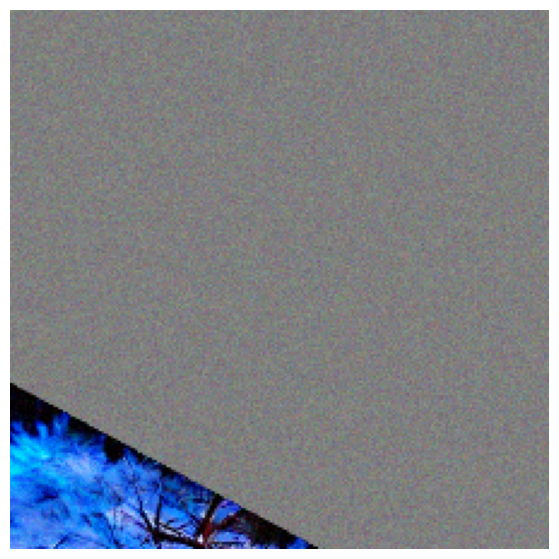

Generation


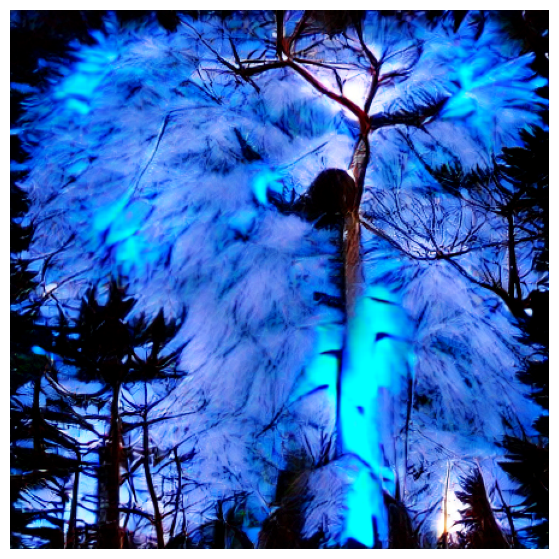

loss: -0.2176513671875 
iteration: 90
Augmented cropped example


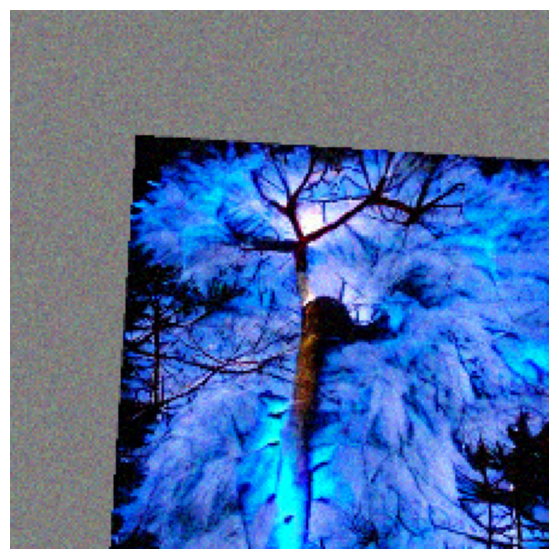

Generation


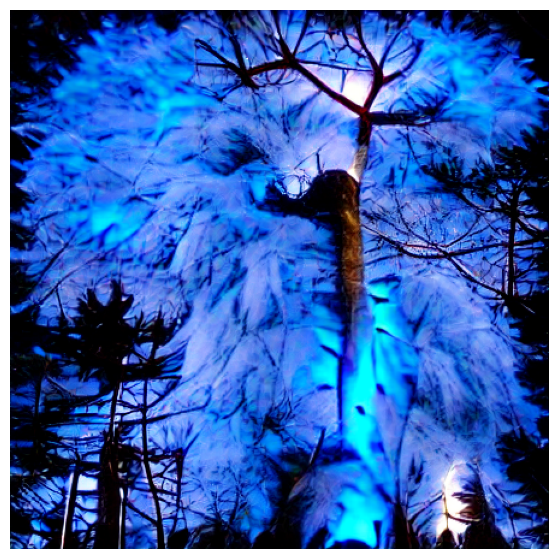

loss: -0.236083984375 
iteration: 100


In [ ]:
torch.cuda.empty_cache()
include=["A Blue tree in the forest"]
exclude='watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)

Augmented cropped example


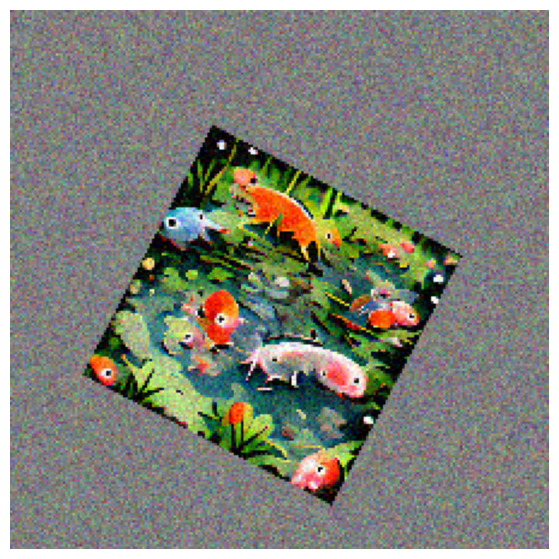

Generation


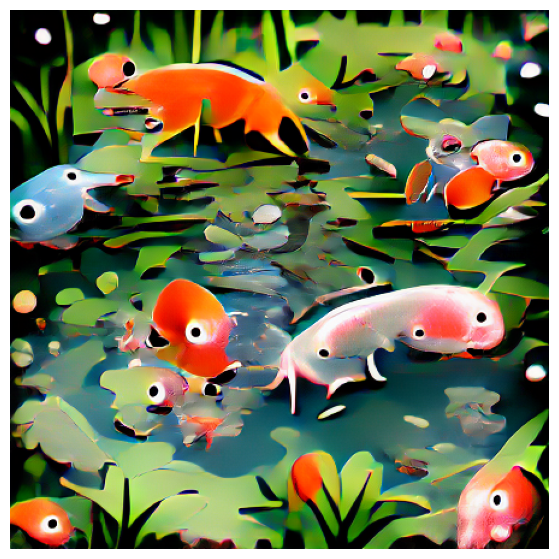

loss: -0.256103515625 
iteration: 80
Augmented cropped example


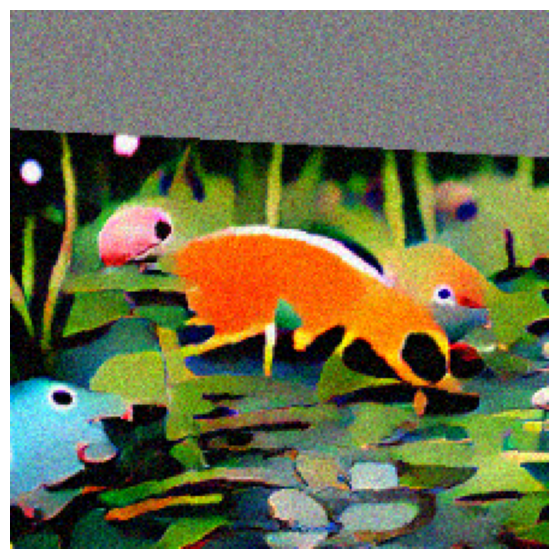

Generation


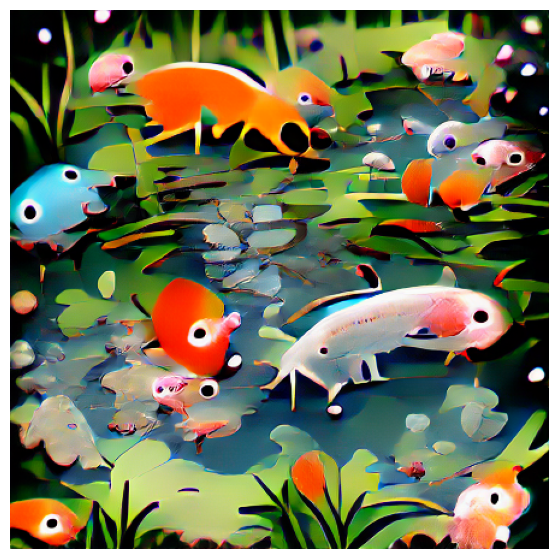

loss: -0.26611328125 
iteration: 90
Augmented cropped example


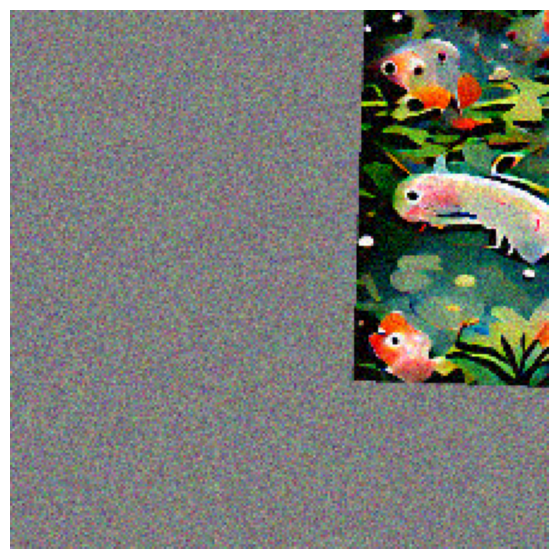

Generation


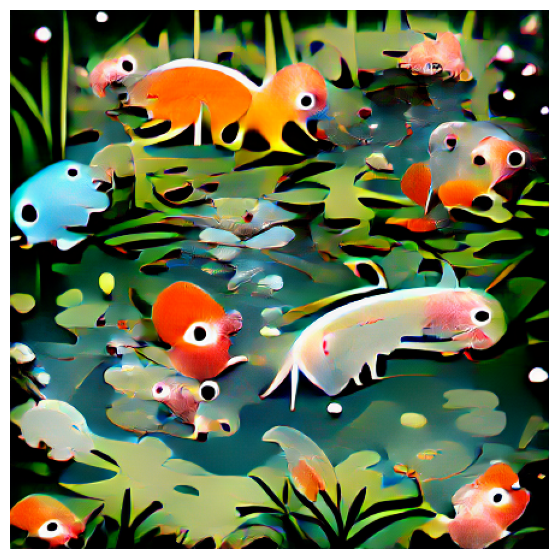

loss: -0.2431640625 
iteration: 100


In [ ]:
torch.cuda.empty_cache()
include=["Small fishes in the pond"]
exclude='watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)